# Approximate Bayesian Computation Example
### January 6, 2020 


[astroML workshop at the 235th Meeting of the American Astronomical Society](http://www.astroml.org/workshops/AAS235.html)

[Zeljko Ivezic, University of Washington](http://faculty.washington.edu/ivezic/) 

[This notebook](https://github.com/...)




## Approximate Bayesian Computation

Astronomical models are often intrinsically stochastic even when modeling data with negligible measurement errors. 

Good examples include simulations of the temperature map of the cosmic microwave background (CMB), of the large-scale structure of a galaxy, and of mass and luminosity distributions for stars and galaxies. In such cases it is hard and often impossible to explicitly write down the data likelihood. 

## Approximate Bayesian Computation

When a simulation is stochastic, one often attempts to vary its input parameters until some adequate metric is well matched between the observed and simulated datasets (e.g., the CMB angular power spectrum, or a parametrized form of the luminosity function). 

With the aid of Approximate Bayesian computation (ABC), this tuning process can be made less ad hoc and much more efficient. An excellent tutorial is Turner & Van Zandt (2012, Journal of Mathematical Psychology 56, 69–85). 

## Approximate Bayesian Computation


The basic idea of ABC is quite simple: produce a large number of models (simulations) by sampling the plausible (prior) values of input parameters and select those that look like the data. 

The distribution of input parameters for the selected subset then approximates the true posterior pdf. 

And then repeat until reaching some pre-defined agreement between the values of a distance metric computed with real and simulated data sets. 

We will consider here a simple example of a 1-dimensional gaussian sample with a known std. deviation. We will use ABC to constrain its location parameter: $\mu$ in $N(\mu, \sigma)$. 

This toy example is trivial - we already know that *the sample mean is the best estimator of the location parameter*. Nevertheless, the structure of more complex examples is identical: only the sample simulator, and perhaps distance metric need to be changed. For example, we could have a simulator of the distribution of galaxies on the sky and use two-point correlation function as a metric, or a simulator of the star formation process that generates luminosities of stars and use luminosity function to construct the distance metric. 



## ABC algorithm: 

Let's assume that data are described by vector $\{x_i\}$, that we have a simulator for producing a model outcome (simulated data vector $\{y_i\}$) given a vector of input parameters $\theta$, and that their prior distribution, p$_0(\theta)$, is known. 

In the first iteration, input parameters $\theta$ are repeatedly sampled from the prior until the simulated dataset $\{y_i\}$ agrees with the data $\{x_i\}$, using some distance metric, and within some initial tolerance
$\epsilon$ (which can be very large). 


## ABC algorithm: 

This sampling is repeated an arbitrary number of times to generate a set of values of desired size (e.g., to estimate precisely its posterior pdf, including higher moments, if needed). 

In every subsequent iteration j, the set of parameter values is improved through incremental approximations to the true posterior distribution. 


## ABC algorithm: 

Just as in the first iteration, new input parameter values are repeatedly drawn from p$_j(\theta_j)$ until 
## $$ D(\{x_i\}|\{y_i\}) < \epsilon_j$$
is satisfied. 

## ABC algorithm: 

p$_j(\theta_j)$ is generated using the $\theta$ values from the previous iteration in a step akin to MCMC, which
effectively selects "particles" from the previous weighted pool, and then perturbs them using the kernel K. 

In each iteration, the threshold value $\epsilon_j$ decreases; it is typically taken as a value in the 
70\%–90\% range of the cumulative distribution of $D(\{x_i\}|\{y_i\})$ in the previous iteration. 
This sampling algorithm is called *Population Monte Carlo ABC*. 
 



The ABC method typically relies on a low-dimensional summary statistic of the data, S(x), such as the sample mean, rather than the full data set. For example, the distance metric between $\{x_i\}$ and $\{y_i\}$ is often defined as

$$ D(\{x_i\}|\{y_i\}) = D(S(x)|S(y))  = |\, {\rm mean}(x) − {\rm mean}(y) \,|.$$

Another example of a distance metric would be $\chi^2$ between two luminosity functions (data vs. simulation), or two two-point correlation functions. 

When $S(x)$ is a sufficient statistic, ABC converges to the true posterior. 

In summary, the two key ABC aspects are the use of low-dimensional summary statistics of the data (instead of data likelihood) and MCMC-like intelligent parameter optimization. 
  
The following code is modeled after  Figure 5.29 from the book: 
https://www.astroml.org/book_figures/chapter5/fig_ABCexample.html


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [59]:
### ABC tools 

# return the gaussian kernel values
def kernelValues(prevThetas, prevStdDev, currentTheta):
    return norm(currentTheta, prevStdDev).pdf(prevThetas)

# return new values, scattered around an old value using gaussian kernel
def kernelSample(theta, stdDev, Nsample=1):
    # returns 1-D array of length N
    return np.random.normal(theta, stdDev, Nsample)

# compute new weight
def computeWeight(prevWeights, prevThetas, prevStdDev, currentTheta):
    denom = prevWeights * kernelValues(prevThetas, prevStdDev, currentTheta)
    return prior(prevThetas) / np.sum(denom)

# flat prior probability
def prior(allThetas):
    return 1.0 / np.size(allThetas)

# kernel scale 
def KLscatter(x, w, N):
    sample = weightedResample(x, N, w)
    # this optimal scale for the kernel was derived by minimizing 
    # the Kullback-Leibler divergence
    return np.sqrt(2) * np.std(sample)

def weightedResample(x, N, weights):
    # resample N elements from x with replacement, with selection 
    # probabilties proportional to provided weights
    p = weights / np.sum(weights)
    # returns 1-D array of length N
    return np.random.choice(x, size=N, replace=True, p=p)

In [21]:
# ABC distance metric 
def distance(x, y):
    return np.abs(np.mean(x) - np.mean(y))

In [49]:
# ABC iterator 
def doABC(data, Niter, Ndraw, D, theta, weights, eps, accrate, simTot, sigmaTrue, verbose=False):
    ssTot = 0
    Ndata = np.size(data)
    
    ## first sample from uniform prior, draw samples and compute their distance to data
    for i in range(0, Ndraw):
        thetaS = np.random.uniform(thetaMin, thetaMax)
        sample = simulateData(Ndata, thetaS, sigmaTrue)
        D[0][i] = distance(data, sample)
        theta[0][i] = thetaS

    weights[0] = 1.0 / Ndraw
    scatter = KLscatter(theta[0], weights[0], Ndraw)
    eps[0] = np.percentile(D[0], 50)
    
    ## continue with ABC iterations of theta 
    for j in range(1, Niter):
        print('iteration:', j)
        thetaOld = theta
        weightsOld = weights / np.sum(weights)
        # sample until distance condition fullfilled
        ss = 0
        for i in range(0, Ndraw):
            notdone = True
            # sample repeatedly until meeting the distance threshold Ndraw times
            while notdone:
                ss += 1
                ssTot += 1
                # sample from previous theta with probability given by weights: thetaS
                # nb: weightedResample returns a 1-D array of length 1
                thetaS = weightedResample(theta[j-1], 1, weights[j-1])[0]
                # perturb thetaS with kernel
                # nb: kernelSample returns a 1-D array of length 1
                thetaSS = kernelSample(thetaS, scatter)[0]
                # generate a simulated sample
                sample = simulateData(Ndata, thetaSS, sigmaTrue)
                # and check the distance threshold 
                dist = distance(data, sample)
                if (dist < eps[j-1]):
                    # met the goal, another acceptable value!
                    notdone = False
            # new accepted parameter value 
            theta[j][i] = thetaSS
            D[j][i] = dist
            # get weight for new theta
            weights[j][i] = computeWeight(weights[j-1], theta[j-1], scatter, thetaSS)
        # collected Ndraw values in this iteration, now 
        # update the kernel scatter value using new values 
        scatter = KLscatter(theta[j], weights[j], Ndraw)
        # threshold for next iteration 
        eps[j] = np.percentile(D[j], DpercCut)
        accrate[j] = 100.0*Ndraw/ss
        simTot[j] = ssTot
        if (verbose):
            print(' number of sim. evals so far:', simTot[j])
            print('     sim. evals in this iter:', ss)
            print('         acceptance rate (%):', accrate[j])
            print('                 new epsilon:', eps[j])
            print('           KL sample scatter:', scatter)
    return ssTot     

In [55]:
def plotABC(theta, weights, Niter, data, muTrue, sigTrue, accrate, simTot):

    Nresample = 100000
    Ndata = np.size(data)
    xmean = np.mean(data)
    sigPosterior = sigTrue / np.sqrt(Ndata)
    truedist = norm(xmean, sigPosterior)
    x = np.linspace(-10, 10, 1000)
    for j in range(0, Niter):
        meanT[j] = np.mean(theta[j])
        stdT[j] = np.std(theta[j])

    # plot
    fig = plt.figure(figsize=(10, 7.5))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.24,
                        bottom=0.1, top=0.95)

    # last few iterations
    ax1 = fig.add_axes((0.55, 0.1, 0.35, 0.38))
    ax1.set_xlabel(r'$\mu$')
    ax1.set_ylabel(r'$p(\mu)$')
    ax1.set_xlim(1.0, 3.0)
    ax1.set_ylim(0, 2.5)
    for j in [15, 20, 25]:
        sample = weightedResample(theta[j], Nresample, weights[j])
        ax1.hist(sample, 20, normed=True, histtype='stepfilled',
                 alpha=0.9-(0.04*(j-15)))
    ax1.plot(x, truedist.pdf(x), 'r')
    ax1.text(1.12, 2.25, 'Iter: 15, 20, 25', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


    # first few iterations
    ax2 = fig.add_axes((0.1, 0.1, 0.35, 0.38))
    ax2.set_xlabel(r'$\mu$')
    ax2.set_ylabel(r'$p(\mu)$')
    ax2.set_xlim(-4.0, 8.0)
    ax2.set_ylim(0, 0.5)
    for j in [2, 4, 6]:
        sample = weightedResample(theta[j], Nresample, weights[j])
        ax2.hist(sample, 20, normed=True, histtype='stepfilled',
                 alpha=(0.9-0.1*(j-2)))
    ax2.text(-3.2, 0.45, 'Iter: 2, 4, 6', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


    # mean and scatter vs. iteration number
    ax3 = fig.add_axes((0.55, 0.60, 0.35, 0.38))
    ax3.set_xlabel('iteration')
    ax3.set_ylabel(r'$<\mu> \pm \, \sigma_\mu$')
    ax3.set_xlim(0, Niter)
    ax3.set_ylim(0, 4)
    iter = np.linspace(1, Niter, Niter)
    meanTm = meanT - stdT
    meanTp = meanT + stdT
    ax3.plot(iter, meanTm)
    ax3.plot(iter, meanTp)
    ax3.plot([0, Niter], [xmean, xmean], ls="--", c="r", lw=1)

    # data
    ax4 = fig.add_axes((0.1, 0.60, 0.35, 0.38))
    ax4.set_xlabel(r'$x$')
    ax4.set_ylabel(r'$p(x)$')
    ax4.set_xlim(-5, 9)
    ax4.set_ylim(0, 0.26)
    ax4.hist(data, 15, normed=True, histtype='stepfilled', alpha=0.8)
    datadist = norm(muTrue, sigTrue)
    ax4.plot(x, datadist.pdf(x), 'r')
    ax4.plot([xmean, xmean], [0.02, 0.07], c='r')
    ax4.plot(data, 0.25 * np.ones(len(data)), '|k')

    # acceptance rate vs. iteration number
    ax5 = fig.add_axes((1.00, 0.60, 0.35, 0.38))
    ax5.set_xlabel('iteration')
    ax5.set_ylabel(r'acceptance rate (%)')
    ax5.set_xlim(0, Niter)
    # ax5.set_ylim(0, 4)
    iter = np.linspace(1, Niter, Niter)
    ax5.plot(iter, accrate)
     
    # the number of simulations vs. iteration number
    ax6 = fig.add_axes((1.00, 0.10, 0.35, 0.38))
    ax6.set_xlabel('iteration')
    ax6.set_ylabel(r'total sims evals')
    ax6.set_xlim(0, Niter)
    # ax6.set_ylim(0, 4)
    iter = np.linspace(1, Niter, Niter)
    ax6.plot(iter, simTot)

    plt.show()

In [24]:
def simulateData(Ndata, mu, sigma):
    # simple gaussian toy model
    return np.random.normal(mu, sigma, Ndata)

def getData(Ndata, mu, sigma):
    # use simulated data
    return simulateData(Ndata, mu, sigma)

In [25]:
# "observed" data:
np.random.seed(0)    # for repeatability
Ndata = 100
muTrue = 2.0
sigmaTrue = 2.0
data = getData(Ndata, muTrue, sigmaTrue)
dataMean = np.mean(data)
# very conservative choice for initial tolerance
eps0 = np.max(data) - np.min(data)
# (very wide) limits for uniform prior
thetaMin = -10
thetaMax = 10

In [26]:
# ABC sampling parameters
Ndraw = 1000
Niter = 26
DpercCut = 80

In [51]:
# arrays for tracking iterations 
theta = np.empty([Niter, Ndraw])
weights = np.empty([Niter, Ndraw])
D = np.empty([Niter, Ndraw])
eps = np.empty([Niter])
accrate = np.empty([Niter])
simTot = np.empty([Niter])
meanT = np.zeros(Niter)
stdT = np.zeros(Niter)

In [52]:
numberSimEvals = doABC(data, Niter, Ndraw, D, theta, weights, eps, accrate, simTot, sigmaTrue, True)

iteration: 1
 number of sim. evals so far: 2728.0
     sim. evals in this iter: 2728
         acceptance rate (%): 36.65689149560117
                 new epsilon: 3.6925823467837193
           KL sample scatter: 3.8861051496307324
iteration: 2
 number of sim. evals so far: 4540.0
     sim. evals in this iter: 1812
         acceptance rate (%): 55.18763796909492
                 new epsilon: 2.8564961261273734
           KL sample scatter: 2.9975618341387458
iteration: 3
 number of sim. evals so far: 6392.0
     sim. evals in this iter: 1852
         acceptance rate (%): 53.99568034557235
                 new epsilon: 2.2015099882968165
           KL sample scatter: 2.280352959362297
iteration: 4
 number of sim. evals so far: 8222.0
     sim. evals in this iter: 1830
         acceptance rate (%): 54.6448087431694
                 new epsilon: 1.693581888606837
           KL sample scatter: 1.7376645404498041
iteration: 5
 number of sim. evals so far: 10026.0
     sim. evals in this iter

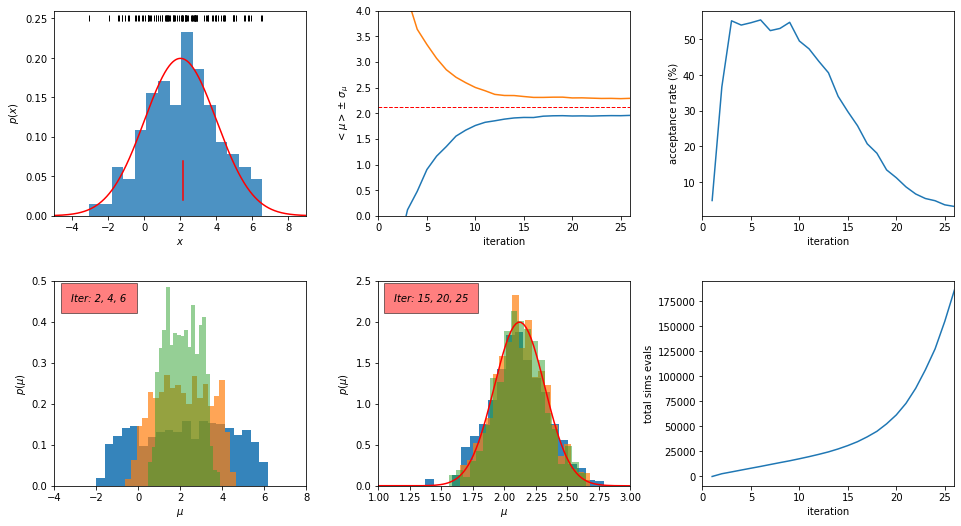

In [56]:
# plot
plotABC(theta, weights, Niter, data, muTrue, sigmaTrue, accrate, simTot)

## Conclusions:

As shown in the top middle panel in the above figure, the ABC algorithm converges to the correct solution in about 15 iterations. 

Between the 15th and the 25th iteration, the tolerance $\epsilon$ decreases from 0.1 to 0.01 and the acceptance probability decreases from 25% to 2.7%. As a result, the total number of simulation evaluations increases by about a factor of six (from about 30,000 to about 180,000), although there is very little gain for our inference of $\mu$. 
 

## Conclusions:

Therefore, the stopping criterion requires careful consideration when the cost of simulations is high (e.g., the maximum acceptable relative change of the estimator can be compared to its uncertainty).

We can have much smaller mnumber of sim evals if we don't care about pretty histograms.

For 100 times smaller Ndraw, we expect about 100 times fewer simulation evaluations. 

Let's do it! 

In [60]:
## LAST POINT: we can have much smaller Ndraw if we don't care about pretty 
## histograms for 100 times smaller Ndraw, expect about 100 times fewer 
## simulation evaluations
Ndraw = 10

In [63]:
# arrays for tracking iterations 
theta = np.empty([Niter, Ndraw])
weights = np.empty([Niter, Ndraw])
D = np.empty([Niter, Ndraw])
# run ABC 
numberSimEvals2 = doABC(data, Niter, Ndraw, D, theta, weights, eps, accrate, simTot, sigmaTrue, True)

iteration: 1
 number of sim. evals so far: 37.0
     sim. evals in this iter: 37
         acceptance rate (%): 27.027027027027028
                 new epsilon: 2.460732782551226
           KL sample scatter: 2.966882899036637
iteration: 2
 number of sim. evals so far: 53.0
     sim. evals in this iter: 16
         acceptance rate (%): 62.5
                 new epsilon: 2.256378122508841
           KL sample scatter: 2.6031669292940904
iteration: 3
 number of sim. evals so far: 72.0
     sim. evals in this iter: 19
         acceptance rate (%): 52.63157894736842
                 new epsilon: 1.8018786733236622
           KL sample scatter: 1.5980978206131289
iteration: 4
 number of sim. evals so far: 91.0
     sim. evals in this iter: 19
         acceptance rate (%): 52.63157894736842
                 new epsilon: 1.6615205677351246
           KL sample scatter: 1.0681300575223631
iteration: 5
 number of sim. evals so far: 109.0
     sim. evals in this iter: 18
         acceptance rate 

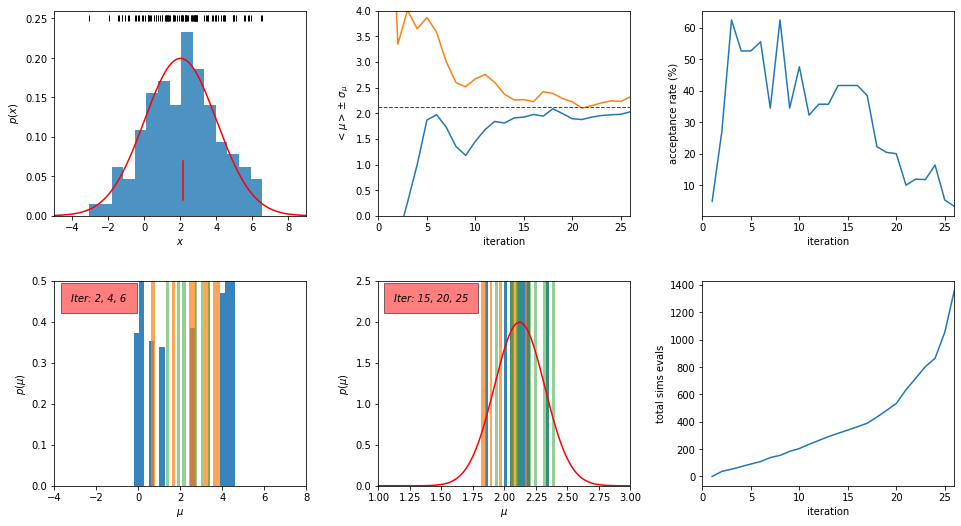

In [64]:
plotABC(theta, weights, Niter, data, muTrue, sigmaTrue, accrate, simTot)


For "professional" implementations of ABC as an open-source Python code see: 

***astroABC***, ***abcpmc***, and ***cosmoabc*** 
